In [52]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

register_matplotlib_converters()
sns.set(style="darkgrid", font_scale=1.5)

LENGTH = 600
LOOK_AHEAD_LENGTH = 40

In [53]:
print(tf.__version__)
tf.config.experimental.list_physical_devices()

2.3.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [54]:
# model = models.load_model('../../models/12kepochs500back40forward_encodedecode')


# Train Model

In [55]:
def shapeData(data, length, look_ahead_length):
    hist = []
    target = []

    for i in range(len(data)-length-look_ahead_length):
        x = data[i:i+length]
        y = data[i+length:i+length+look_ahead_length]
        hist.append(x)
        target.append(y)
    
    # Convert into numpy arrays and shape correctly (len(dataset), length) and (len(dataset), 1) respectivly
    hist = np.array(hist)
    target = np.array(target)
    hist = hist.reshape((len(hist), length, 1))

    return(hist, target)

In [56]:
def trainModel(datasets, length, model=None, quiet=False):
    for dataset in datasets:
        X_train, y_train = shapeData(dataset, length, LOOK_AHEAD_LENGTH)

        if not model:
            # Create model and compile if not already passed a model
            model = tf.keras.Sequential()
            model.add(layers.LSTM(units=50, input_shape=(length,1), dropout=0.2, activation='tanh'))
            model.add(layers.RepeatVector(LOOK_AHEAD_LENGTH))
            model.add(layers.LSTM(units=100, return_sequences=True, dropout=0.2, activation='tanh'))
            model.add(layers.TimeDistributed(layers.Dense(50, activation='tanh')))
            model.add(layers.TimeDistributed(layers.Dense(1)))
            model.compile(optimizer='adam', loss='mean_squared_error')
            print(model.summary())
        else:
            print("Continuing training from where we left off...")

        # Perform training
        output = 1
        if quiet:
            output = 0
        history = model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=output, shuffle=False)

        # Show loss
        if not quiet:
            loss = history.history['loss']
            epoch_count = range(1, len(loss) + 1)
            plt.figure(figsize=(6,4))
            plt.plot(epoch_count, loss, 'r--')
            plt.legend(['Training Loss'])
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()

    return model

In [57]:
def scaleData(paths):
    scaler = MinMaxScaler()
    datasets = []
    for path in paths:
        # perform partial fits on all datasets
        
        new_df = pd.DataFrame()
        new_df["price"] = pd.read_csv(path)[["high_price","low_price"]].mean(axis=1)
        
        datasets.append(new_df)

        scaler = scaler.partial_fit(datasets[-1])
    for i in range(len(datasets)):
        # once all partial fits have been performed, transform every file
        datasets[i] = scaler.transform(datasets[i])
    return (datasets, scaler)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 50)                10400     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 40, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 40, 100)           60400     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 40, 50)            5050      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 40, 1)             51        
Total params: 75,901
Trainable params: 75,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
54/54 [==============================] - 8s 152ms/step - loss: 0.0131
Epoch 2/1000
54/54 [========

Epoch 86/1000
54/54 [==============================] - 8s 157ms/step - loss: 0.0081
Epoch 87/1000
54/54 [==============================] - 9s 158ms/step - loss: 0.0064
Epoch 88/1000
54/54 [==============================] - 9s 158ms/step - loss: 0.0058
Epoch 89/1000
54/54 [==============================] - 8s 157ms/step - loss: 0.0052
Epoch 90/1000
54/54 [==============================] - 9s 158ms/step - loss: 0.0052
Epoch 91/1000
54/54 [==============================] - 9s 158ms/step - loss: 0.0053
Epoch 92/1000
54/54 [==============================] - 8s 157ms/step - loss: 0.0055
Epoch 93/1000
54/54 [==============================] - 9s 158ms/step - loss: 0.0055
Epoch 94/1000
54/54 [==============================] - 8s 157ms/step - loss: 0.0055
Epoch 95/1000
54/54 [==============================] - 9s 158ms/step - loss: 0.0050
Epoch 96/1000
54/54 [==============================] - 8s 157ms/step - loss: 0.0064
Epoch 97/1000
54/54 [==============================] - 9s 158ms/step - loss:

54/54 [==============================] - 9s 160ms/step - loss: 0.0021
Epoch 183/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0022
Epoch 184/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0024
Epoch 185/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0025
Epoch 186/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0026
Epoch 187/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0026
Epoch 188/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0035
Epoch 189/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0034
Epoch 190/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0045
Epoch 191/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0041
Epoch 192/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0050
Epoch 193/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.

54/54 [==============================] - 9s 159ms/step - loss: 0.0012
Epoch 279/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0011
Epoch 280/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0011
Epoch 281/1000
54/54 [==============================] - 9s 161ms/step - loss: 0.0012
Epoch 282/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0014
Epoch 283/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0015
Epoch 284/1000
54/54 [==============================] - 9s 159ms/step - loss: 0.0015
Epoch 285/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0014
Epoch 286/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0014
Epoch 287/1000
54/54 [==============================] - 9s 161ms/step - loss: 0.0014
Epoch 288/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0014
Epoch 289/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.

Epoch 374/1000
54/54 [==============================] - 9s 161ms/step - loss: 9.2677e-04
Epoch 375/1000
54/54 [==============================] - 9s 161ms/step - loss: 9.1093e-04
Epoch 376/1000
54/54 [==============================] - 9s 161ms/step - loss: 9.0684e-04
Epoch 377/1000
54/54 [==============================] - 9s 160ms/step - loss: 9.4141e-04
Epoch 378/1000
54/54 [==============================] - 9s 161ms/step - loss: 0.0010
Epoch 379/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0011
Epoch 380/1000
54/54 [==============================] - 9s 162ms/step - loss: 0.0012
Epoch 381/1000
54/54 [==============================] - 9s 161ms/step - loss: 0.0013
Epoch 382/1000
54/54 [==============================] - 9s 162ms/step - loss: 0.0012
Epoch 383/1000
54/54 [==============================] - 9s 161ms/step - loss: 0.0011
Epoch 384/1000
54/54 [==============================] - 9s 161ms/step - loss: 0.0011
Epoch 385/1000
54/54 [===========================

54/54 [==============================] - 9s 162ms/step - loss: 7.7491e-04
Epoch 468/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0012
Epoch 469/1000
54/54 [==============================] - 9s 161ms/step - loss: 0.0018
Epoch 470/1000
54/54 [==============================] - 9s 161ms/step - loss: 0.0020
Epoch 471/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0018
Epoch 472/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0018
Epoch 473/1000
54/54 [==============================] - 9s 161ms/step - loss: 0.0017
Epoch 474/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0020
Epoch 475/1000
54/54 [==============================] - 9s 160ms/step - loss: 0.0015
Epoch 476/1000
54/54 [==============================] - 9s 162ms/step - loss: 0.0015
Epoch 477/1000
54/54 [==============================] - 9s 161ms/step - loss: 7.5415e-04
Epoch 478/1000
54/54 [==============================] - 9s 161ms/step - 

54/54 [==============================] - 9s 167ms/step - loss: 2.9851e-04
Epoch 561/1000
54/54 [==============================] - 9s 166ms/step - loss: 3.6365e-04
Epoch 562/1000
54/54 [==============================] - 9s 167ms/step - loss: 4.6369e-04
Epoch 563/1000
54/54 [==============================] - 9s 167ms/step - loss: 6.4909e-04
Epoch 564/1000
54/54 [==============================] - 9s 166ms/step - loss: 9.5119e-04
Epoch 565/1000
54/54 [==============================] - 9s 166ms/step - loss: 0.0014
Epoch 566/1000
54/54 [==============================] - 9s 167ms/step - loss: 0.0016
Epoch 567/1000
54/54 [==============================] - 9s 166ms/step - loss: 0.0016
Epoch 568/1000
54/54 [==============================] - 9s 166ms/step - loss: 0.0011
Epoch 569/1000
54/54 [==============================] - 9s 167ms/step - loss: 0.0010
Epoch 570/1000
54/54 [==============================] - 9s 167ms/step - loss: 5.8435e-04
Epoch 571/1000
54/54 [==============================] - 

54/54 [==============================] - 9s 167ms/step - loss: 0.0012
Epoch 654/1000
54/54 [==============================] - 9s 166ms/step - loss: 9.3744e-04
Epoch 655/1000
54/54 [==============================] - 9s 167ms/step - loss: 9.4191e-04
Epoch 656/1000
54/54 [==============================] - 9s 167ms/step - loss: 7.1832e-04
Epoch 657/1000
54/54 [==============================] - 9s 166ms/step - loss: 5.4727e-04
Epoch 658/1000
54/54 [==============================] - 9s 167ms/step - loss: 3.9213e-04
Epoch 659/1000
54/54 [==============================] - 9s 166ms/step - loss: 2.8814e-04
Epoch 660/1000
54/54 [==============================] - 9s 167ms/step - loss: 2.3508e-04
Epoch 661/1000
54/54 [==============================] - 9s 167ms/step - loss: 2.1384e-04
Epoch 662/1000
54/54 [==============================] - 9s 167ms/step - loss: 2.0715e-04
Epoch 663/1000
54/54 [==============================] - 9s 167ms/step - loss: 2.0902e-04
Epoch 664/1000
54/54 [==================

54/54 [==============================] - 9s 167ms/step - loss: 2.8398e-04
Epoch 747/1000
54/54 [==============================] - 9s 167ms/step - loss: 2.7840e-04
Epoch 748/1000
54/54 [==============================] - 9s 167ms/step - loss: 2.7765e-04
Epoch 749/1000
54/54 [==============================] - 9s 167ms/step - loss: 2.8000e-04
Epoch 750/1000
54/54 [==============================] - 9s 166ms/step - loss: 2.8234e-04
Epoch 751/1000
54/54 [==============================] - 9s 167ms/step - loss: 2.8666e-04
Epoch 752/1000
54/54 [==============================] - 9s 168ms/step - loss: 2.9349e-04
Epoch 753/1000
54/54 [==============================] - 9s 168ms/step - loss: 2.9981e-04
Epoch 754/1000
54/54 [==============================] - 9s 167ms/step - loss: 3.0440e-04
Epoch 755/1000
54/54 [==============================] - 9s 167ms/step - loss: 3.0702e-04
Epoch 756/1000
54/54 [==============================] - 9s 168ms/step - loss: 3.1057e-04
Epoch 757/1000
54/54 [==============

54/54 [==============================] - 9s 170ms/step - loss: 2.3557e-04
Epoch 839/1000
54/54 [==============================] - 9s 170ms/step - loss: 2.5609e-04
Epoch 840/1000
54/54 [==============================] - 9s 168ms/step - loss: 3.0114e-04
Epoch 841/1000
54/54 [==============================] - 9s 169ms/step - loss: 3.7804e-04
Epoch 842/1000
54/54 [==============================] - 9s 168ms/step - loss: 4.8531e-04
Epoch 843/1000
54/54 [==============================] - 9s 169ms/step - loss: 5.9863e-04
Epoch 844/1000
54/54 [==============================] - 9s 169ms/step - loss: 6.3840e-04
Epoch 845/1000
54/54 [==============================] - 9s 168ms/step - loss: 5.4477e-04
Epoch 846/1000
54/54 [==============================] - 9s 170ms/step - loss: 5.6179e-04
Epoch 847/1000
54/54 [==============================] - 9s 169ms/step - loss: 5.9885e-04
Epoch 848/1000
54/54 [==============================] - 9s 169ms/step - loss: 6.3995e-04
Epoch 849/1000
54/54 [==============

54/54 [==============================] - 9s 169ms/step - loss: 8.6341e-04
Epoch 931/1000
54/54 [==============================] - 9s 169ms/step - loss: 0.0014
Epoch 932/1000
54/54 [==============================] - 9s 169ms/step - loss: 0.0016
Epoch 933/1000
54/54 [==============================] - 9s 169ms/step - loss: 0.0013
Epoch 934/1000
54/54 [==============================] - 9s 170ms/step - loss: 0.0016
Epoch 935/1000
54/54 [==============================] - 9s 169ms/step - loss: 0.0014
Epoch 936/1000
54/54 [==============================] - 9s 169ms/step - loss: 0.0015
Epoch 937/1000
54/54 [==============================] - 9s 169ms/step - loss: 0.0011
Epoch 938/1000
54/54 [==============================] - 9s 169ms/step - loss: 4.1393e-04
Epoch 939/1000
54/54 [==============================] - 9s 169ms/step - loss: 2.5580e-04
Epoch 940/1000
54/54 [==============================] - 9s 168ms/step - loss: 2.3508e-04
Epoch 941/1000
54/54 [==============================] - 9s 170ms

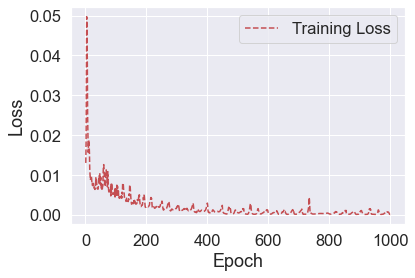

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: E-D-1k-600back-40forward\assets
Completed 1k epochs and saved model
Continuing training from where we left off...
Epoch 1/1000
54/54 [==============================] - 8s 152ms/step - loss: 2.1059e-04
Epoch 2/1000
54/54 [==============================] - 8s 155ms/step - loss: 2.1919e-04
Epoch 3/1000
54/54 [==============================] - 10s 181ms/step - loss: 2.2258e-04
Epoch 4/1000
54/54 [==============================] - 10s 187ms/step - loss: 2.2270e-04
Epoch 5/1000
54/54 [==============================] - 10s 188ms/step - loss: 2.1919e-042s - lo
Epoch 6/1000
54/54 [==============================] - 10s 186ms/step - loss: 2.1451e-04
Epoch 7/1000
54/54 [==============================] - 10s 189ms/step - loss: 2.1002e

Epoch 78/1000
54/54 [==============================] - 10s 190ms/step - loss: 6.5970e-04
Epoch 79/1000
54/54 [==============================] - 10s 188ms/step - loss: 6.9115e-04
Epoch 80/1000
54/54 [==============================] - 10s 188ms/step - loss: 6.9842e-04
Epoch 81/1000
54/54 [==============================] - 10s 188ms/step - loss: 6.2954e-04
Epoch 82/1000
54/54 [==============================] - 10s 188ms/step - loss: 6.0178e-04
Epoch 83/1000
54/54 [==============================] - 10s 190ms/step - loss: 5.0236e-04
Epoch 84/1000
54/54 [==============================] - 10s 189ms/step - loss: 3.5747e-04
Epoch 85/1000
54/54 [==============================] - 10s 189ms/step - loss: 2.3874e-04
Epoch 86/1000
54/54 [==============================] - 10s 188ms/step - loss: 1.8809e-04
Epoch 87/1000
54/54 [==============================] - 10s 188ms/step - loss: 1.8067e-04
Epoch 88/1000
54/54 [==============================] - 10s 188ms/step - loss: 1.8783e-04
Epoch 89/1000
54/54 [

54/54 [==============================] - 10s 187ms/step - loss: 5.2997e-04
Epoch 168/1000
54/54 [==============================] - 10s 188ms/step - loss: 3.9811e-04
Epoch 169/1000
54/54 [==============================] - 10s 188ms/step - loss: 2.6010e-04
Epoch 170/1000
54/54 [==============================] - 10s 188ms/step - loss: 1.9004e-04
Epoch 171/1000
54/54 [==============================] - 10s 187ms/step - loss: 1.7562e-04
Epoch 172/1000
54/54 [==============================] - 10s 189ms/step - loss: 1.7762e-04
Epoch 173/1000
54/54 [==============================] - 10s 188ms/step - loss: 1.8321e-04
Epoch 174/1000
54/54 [==============================] - 10s 188ms/step - loss: 1.8735e-04
Epoch 175/1000
54/54 [==============================] - 10s 188ms/step - loss: 1.8892e-04
Epoch 176/1000
54/54 [==============================] - 10s 188ms/step - loss: 1.8784e-04
Epoch 177/1000
54/54 [==============================] - 10s 188ms/step - loss: 1.8409e-041s - loss:
Epoch 178/1000


In [ ]:
model = None
for i in np.arange(1, 20):
    paths = ["../../data/ETH.csv"]
    datasets, scaler = scaleData(paths)
    model = trainModel(datasets, LENGTH, model)
    model.save(f"E-D-{i}k-600back-40forward")
    print(f"Completed {i}k epochs and saved model")

## Test Model

In [ ]:
def testModel(model, path_to_testing_dataset, quiet=False):

    datasets, scaler = scaleData([path_to_testing_dataset])

    hist, actual = shapeData(datasets[0], LENGTH, LOOK_AHEAD_LENGTH)

    pred = model.predict(hist)

    
    # for p in pred:
    # pred_transformed.append(scaler.inverse_transform(p))
    pred_transformed = scaler.inverse_transform(pred[0])
    actual_transformed = scaler.inverse_transform(actual[0])
    hist_transformed = scaler.inverse_transform(hist[0])

    
    # print(pred[500])
    # print(hist[0])
    if not quiet:
        plt.figure(figsize=(12,8))
        plt.plot(hist_transformed, color='blue', label='History')
        plt.plot(np.arange(len(hist_transformed)-1,len(hist_transformed)+LOOK_AHEAD_LENGTH-1),pred_transformed, color='red', label='Prediction')
        plt.plot(np.arange(len(hist_transformed)-1,len(hist_transformed)+LOOK_AHEAD_LENGTH-1),actual_transformed, color='purple', label='Actual')
        plt.title('ETH Price Prediction')
        plt.legend()
        plt.show()

        pred_transformed = scaler.inverse_transform(pred[900])
        actual_transformed = scaler.inverse_transform(actual[900])
        hist_transformed = scaler.inverse_transform(hist[900])
        plt.figure(figsize=(12,8))
        plt.plot(hist_transformed, color='blue', label='History')
        plt.plot(np.arange(len(hist_transformed)-1,len(hist_transformed)+LOOK_AHEAD_LENGTH-1),pred_transformed, color='red', label='Prediction')
        plt.plot(np.arange(len(hist_transformed)-1,len(hist_transformed)+LOOK_AHEAD_LENGTH-1),actual_transformed, color='purple', label='Actual')
        plt.title('ETH Price Prediction')
        plt.legend()
        plt.show()

    return


In [ ]:
testModel(model, "../../data/ETH.csv")

# Single Prediction

In [ ]:
# For example, if we just want to predict the next timestep in the dataset we can prepare it as such:

# 1. get the [length] last points from the data set since that's what we care about
length = LENGTH
whole_df = pd.read_csv('../../data/ETH.csv')
# most_recent_period = np.array(recent_history)
recent_history = pd.DataFrame({'price': whole_df[["high_price","low_price"]].mean(axis=1)}).tail(length)
recent_history = recent_history.set_index(pd.DatetimeIndex(pd.to_datetime(whole_df['begins_at'].tail(length))))

# 2. convert to numpy array 
most_recent_period = np.array(recent_history)

# 3. normalize data
scaler = MinMaxScaler()
most_recent_period_scaled = scaler.fit_transform(most_recent_period)

# 4. reshape to the 3D tensor we expected (1, length, 1)
most_recent_period_scaled_shaped = most_recent_period_scaled.reshape((1, length, 1))

# 5. Predict
prediction = model.predict(most_recent_period_scaled_shaped)
# print(prediction[0])
# 6. Un-normalize the data
result = scaler.inverse_transform(prediction[0])
recent_history_unscaled = scaler.inverse_transform(most_recent_period_scaled)
recent_history.price = recent_history_unscaled

# print(result)
pred_df = pd.DataFrame(result)
# pred_df = pred_df.set_index(pd.DatetimeIndex(pd.date_range(recent_history.index[-1], periods=len(result[0]), freq="15s")))
plt.figure(figsize=(20,8))
plt.plot(recent_history_unscaled)
plt.plot(np.arange(length, length+LOOK_AHEAD_LENGTH),result)
plt.show()